<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Time Series Observation

## Spec2: Assign_wcs()
<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* logging
* astropy.io for opening fits files
* astropy.utils for remote data retrieval
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot a shape
* pysiaf for SIAF access
* miricoord for coordinate conversion tools
* gwcs for wcs tools

[Top of Page](#title_ID)

In [14]:
import inspect
import numpy as np
import glob
import logging
from IPython.display import Markdown
from jwst.datamodels import RampModel, ImageModel, CubeModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.assign_wcs import AssignWcsStep
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import astropy.io.fits as fits
from astropy.utils.data import download_file
from gwcs.wcstools import grid_from_bounding_box

from pysiaf import Siaf
import miricoord.imager.mirim_tools as mt

%matplotlib inline


<a id="intro_ID"></a>
# Introduction


In this notebook we will test the assign_wcs step of Spec2Pipeline() for LRS Time Series Observations (TSOs), i.e. LRS in slitless mode.

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/source_catalog


### Calibration WG Requested Algorithm: 

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information



[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated TSO observation, generated with MIRISim. It is a single exposure of a star with 100 groups per integration and 10 integrations. LRS TSOs uses the SLITLESSPRISM subarray, so the data do not cover the full array. 

The data are stored on Box and we will retrieve from there.

[Top of Page](#title_ID)

In [3]:
mainurl ="https://data.science.stsci.edu/redirect/JWST/TSO/pipeline_testing_miri_LRS_tso/"
fname = 'pipetest_miri_lrs_tso_100G10I.fits'
fdld = download_file(mainurl+fname)
hdu = fits.open(fdld)
hdu.info()
sci_mod = RampModel(hdu)

Filename: /var/folders/lf/br5qbz194xd6951d98qqk2ym0000gn/T/astropy-download-76955-n8sm8yhr
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     116   ()      
  1  SCI           1 ImageHDU        51   (72, 416, 100, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (72, 416)   int32 (rescales to uint32)   
  3  REFOUT        1 ImageHDU        11   (18, 416, 100, 10)   float32   
  4  ASDF          1 BinTableHDU     11   1R x 1C   [5990B]   


<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_tso1.cfg file. The output of this stage will then be run through the assign_wcs step, which is part of the Spec2Pipeline. 

[Top of Page](#title_ID)

### CalDetector1

We first run the data through the Detector1 pipeline, ensuring to pass the calwebb_tso1.cfg configuration file. 

In [5]:
det1_step = Detector1Pipeline()
det1 = det1_step.call(sci_mod, config_file='calwebb_tso1.cfg', save_results=True)


2020-07-24 14:51:04,668 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-07-24 14:51:04,670 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-07-24 14:51:04,672 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-07-24 14:51:04,673 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-07-24 14:51:04,675 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-07-24 14:51:04,677 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-07-24 14:51:04,679 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-07-24 14:51:04,680 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-07-24 14:51:04,682 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-07-24 14:51:04,684 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-07-24 

2020-07-24 14:51:06,108 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'astropy-download-76955-n8sm8yhr' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'rscd', 'saturation', 'superbias']
2020-07-24 14:51:06,116 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits'.
2020-07-24 14:51:06,116 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.
2020-07-24 14:51:06,117 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.
2020-07-24 14:51:06,118 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.
2020-07-24 14:51:06,118 - stpipe.Detector1Pipeline - INFO - 

2020-07-24 14:51:10,005 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(10, 100, 416, 72) from astropy-download-76955-n8sm8yhr>,).
2020-07-24 14:51:10,007 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2020-07-24 14:51:10,023 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/kendrew//crds_cache/references/jwst/miri/jwst_miri_dark_0048.fits
2020-07-24 14:51:10,667 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0
2020-07-24 14:51:10,668 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2020-07-2

2020-07-24 14:52:41,681 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}
2020-07-24 14:52:41,716 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2020-07-24 14:52:41,717 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2020-07-24 14:52:41,720 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2020-07-24 14:52:41,842 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from astropy-download-76955-n8sm8yhr_ramp.fits>,).
2020-07-24 14:52:41,844 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None,

### AssignWcs

The AssignWcs step should not change anything in the science data or error extension. It attaches the WCS information to the data, so that a location in detector pixels can be reconstructed to an RA, dec, wavelength in spatial and spectral space. 

In [15]:
rfile = glob.glob('*_rate.fits')
rifile = glob.glob('*_rateints.fits')
print(rfile)
print(rifile)

rmod = ImageModel(rfile[0])
rimod = CubeModel(rifile[0])

wcs_step = AssignWcsStep()
wcsmod = wcs_step.call(rifile[0], save_results=True)

['astropy-download-76955-n8sm8yhr_rate.fits']
['astropy-download-76955-n8sm8yhr_rateints.fits']


2020-07-27 15:38:36,317 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-27 15:38:36,455 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-27 15:38:36,460 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-27 15:38:36,859 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('astropy-download-76955-n8sm8yhr_rateints.fits',).
2020-07-27 15:38:36,860 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-07-27 15:38:37,470 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-slitless pipeline with references {'distortion': '/Users/kendrew//c

<a id="residual_ID"></a>
## Output checks and tests

We can use the output model to run teh following checks:

* the SCI extension is unchanged from the step input (check with 1 integration)
* we visualize the location of the bounding box.
* we use the wcs information assigned in the step to check the RA, dec, wavelength assignment at some reference locations. 

[Top of Page](#title_ID)

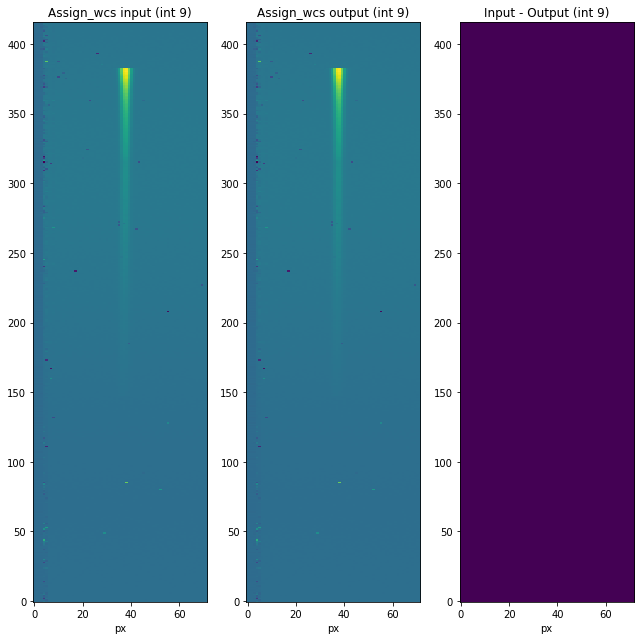

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[9,9])
ax[0].imshow(rimod.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax[0].set_title('Assign_wcs input (int 9)')
ax[0].set_xlabel('px')
ax[0].set_xlabel('px')

ax[1].imshow(wcs.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax[1].set_title('Assign_wcs output (int 9)')
ax[1].set_xlabel('px')
ax[1].set_xlabel('px')

diff = rimod.data[9,:,:] - wcs.data[9,:,:]
ax[2].imshow(diff, origin='lower', interpolation='None', aspect='auto')
ax[2].set_title('Input - Output (int 9)')
ax[2].set_xlabel('px')
ax[2].set_xlabel('px')

fig.tight_layout()

# Do a numeric check between input and output
assert np.mean(diff) <= 1e-6, "Check differences between step input and output"



In [21]:
bbox_w = wcsmod.meta.wcs.bounding_box[0][1] - wcsmod.meta.wcs.bounding_box[0][0]
bbox_ht = wcsmod.meta.wcs.bounding_box[1][1] - wcsmod.meta.wcs.bounding_box[1][0]
print('Model bbox = {0} '.format(wcsmod.meta.wcs.bounding_box))
print('Model: Height x width of bounding box = {0} x {1} pixels'.format(bbox_ht, bbox_w))

# make sure that the size of the bounding box is smaller than the subarray
assert bbox_ht <= np.shape(wcsmod.data)[1], "Bounding box size incompatible with subarray"
assert bbox_w <= np.shape(wcsmod.data)[2], "Bounding box size incompatible with subarray"

Model bbox = ((3.5, 71.5), (6.5, 397.5)) 
Model: Height x width of bounding box = 391.0 x 68.0 pixels


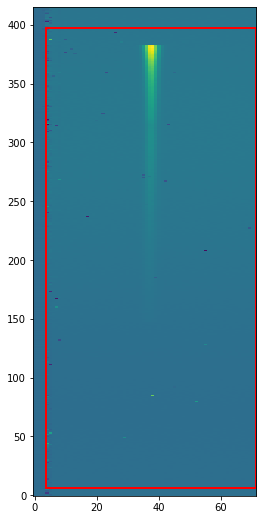

In [26]:
fig, ax = plt.subplots(figsize=[4,9])
bbox = Rectangle((wcsmod.meta.wcs.bounding_box[0][0],wcsmod.meta.wcs.bounding_box[1][0]), bbox_w, bbox_ht, angle=0.0, ec='r', lw=2, fc='None')

ax.imshow(wcs.data[9,:,:], origin='lower', interpolation='None', aspect='auto')
ax.add_patch(bbox)

In [33]:
# Check the positions and wavelengths of a few representative pixels
siaf = Siaf('MIRI')
ap = siaf['MIRIM_SLITLESSPRISM']
refpx = ap.reference_point(to_frame='det')
print(refpx)

testpx = [r-1. for r in refpx]
print(testpx)

wcsmod.meta.wcs(37.5, 828.)
#ra, dec, lam = wcsmod.meta.wcs(testpx[0], testpx[1])


(38.5, 829.0)
[37.5, 828.0]


[nan, nan, nan]

<a id="about_ID"></a>
## About this Notebook
**Author:** Sarah Kendrew, ESA MIRI Instrument & Calibration Scientist, MIRI branch
<br>**Updated On:** 07/27/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 